In [ ]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from torch import nn,manual_seed,from_numpy, split, tensor
import torch.optim as optim
import torch
import time
import os

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

In [ ]:
def calaculate_accuracy_classifier(model,data,device):
  correct_1, total_1 = 0., 0.
  correct_2, total_2 = 0., 0.
  correct_3, total_3 = 0., 0.
  correct_4, total_4 = 0., 0.
  numBatch = 0
  while numBatch < len(data):
    corrFunc, labels = data[numBatch]
    numBatch = numBatch + 1
    corrFunc, labels = corrFunc.to(device), labels.to(device)
    Y_pred = model.forward(corrFunc.float()) # get output
    max_1,max_2,max_3,max_4 = [],[],[],[]
    for i in labels:
      max_1.append(i[0].item())
      max_2.append(i[1].item())
      max_3.append(i[2].item())
      max_4.append(i[3].item())
    max_1,max_2,max_3,max_4  = torch.tensor(max_1).to(device),torch.tensor(max_2).to(device),\
              torch.tensor(max_3).to(device),torch.tensor(max_4).to(device)
    max_1,max_2,max_3,max_4 = max_1.to(device),max_2.to(device),max_3.to(device),max_4.to(device)
    _, predicted_1 = torch.max(Y_pred[0].data, 1) # get predicted class
    _, predicted_2 = torch.max(Y_pred[1].data, 1)
    _, predicted_3 = torch.max(Y_pred[2].data, 1)
    _, predicted_4 = torch.max(Y_pred[3].data, 1)
    total_1 += max_1.size(0) # all examples
    total_2 += max_2.size(0) # all examples
    total_3 += max_3.size(0) # all examples
    total_4 += max_4.size(0) # all examples
    correct_1 += (predicted_1 == max_1).sum().item()
    correct_2 += (predicted_2 == max_2).sum().item()
    correct_3 += (predicted_3 == max_3).sum().item()
    correct_4 += (predicted_4 == max_4).sum().item()
  return correct_1/total_1,correct_2/total_2,correct_3/total_3,correct_4/total_4

In [ ]:
def dataConvertor(data):
    inputData = []
    outputData = []
    for i in data:
        inputData.append(i[0])
        outputData.append(i[1])
    return tensor(inputData),tensor(outputData)


def dataBatching(data,batch_len=1):
    inputData =  split(data[0],batch_len)
    outputData = split(data[1],batch_len)
    batchedData = []
    for i in range(len(inputData)):
        batchedData.append([inputData[i],outputData[i]])
    return batchedData

In [ ]:
def loss_classifier(criterion,predict,original,device):
  criterion = nn.CrossEntropyLoss()
  loss_1,loss_2,loss_3,loss_4 = [],[],[],[]
  for i in original:
    loss_1.append(i[0].item())
    loss_2.append(i[1].item())
    loss_3.append(i[2].item())
    loss_4.append(i[3].item())
  loss_1,loss_2,loss_3,loss_4 = torch.tensor(loss_1).to(device),torch.tensor(loss_2).to(device),\
              torch.tensor(loss_3).to(device),torch.tensor(loss_4).to(device)
  total_loss = criterion(predict[0],loss_1)+criterion(predict[1],loss_2)+\
  criterion(predict[2],loss_3)+criterion(predict[3],loss_4)
  return total_loss

  

classification report (sklearn)

In [ ]:


baseSeq = nn.Sequential(
     nn.Linear(9, 200),
     nn.ReLU(),
     nn.BatchNorm1d(200),
     nn.Linear(200, 2000),
     nn.ReLU(),
     nn.BatchNorm1d(2000),
     nn.Linear(2000, 4000),
     nn.ReLU(),
     nn.BatchNorm1d(4000),
     nn.Linear(4000, 700),
     nn.ReLU(),
     nn.BatchNorm1d(700),
     nn.Linear(700, 50),
     nn.ReLU(),
     nn.BatchNorm1d(50)
)


class GPNN_classifier(nn.Module):
    def __init__(self, Seq = baseSeq, init_form = "normal"):
        super().__init__()
        self.layers_stack = Seq
        self.exit_1 = nn.Sequential(nn.Linear(50, 2))
        self.exit_2 = nn.Sequential(nn.Linear(50, 2))
        self.exit_3 = nn.Sequential(nn.Linear(50, 2))
        self.exit_4 = nn.Sequential(nn.Linear(50, 2))
        self.init_form = init_form
        if self.init_form is not None:
            self.init()
            

    def forward(self, x):
        x = self.layers_stack(x)
        return self.exit_1(x),self.exit_2(x),self.exit_3(x),self.exit_4(x)
  
    def init(self):
        relu_gain = torch.nn.init.calculate_gain("relu")
        for child in self.layers_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight,
                                                 nonlinearity='relu')
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight,
                                                  nonlinearity='relu')
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()



def trainGPNN_c(model, trainloader,testloader,device = 'cpu', num_epochs = 2, criterion = nn.MSELoss,\
              optimizer = optim.Adam,learning_rate = 0.001,maxBatch = 10):

    
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist_train = [] # for plotting
    loss_hist_test = []
    acc_test_1,acc_test_2,acc_test_3,acc_test_4 = [],[],[],[]
    acc_train_1,acc_train_2,acc_train_3,acc_train_4 = [],[],[],[]
    for epoch in range(num_epochs):
        hist_loss = 0
        numBatch = 0
        model.train()
        while numBatch < maxBatch:
            corrFunc, values = trainloader[numBatch]
            corrFunc, values = corrFunc.to(device), values.to(device)
            numBatch = numBatch + 1
            optimizer.zero_grad()
            loss = loss_classifier(criterion, model(corrFunc), values,device)
            loss.backward()    
            optimizer.step()
            hist_loss += loss.item()
        loss_hist_train.append(hist_loss /len(trainloader))
        
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          while numBatch < maxBatch:
            corrFunc, values = testloader[numBatch]
            corrFunc, values = corrFunc.to(device), values.to(device)
            predict = model(corrFunc)
            loss = loss_classifier(criterion, model(corrFunc), values,device)
            test_loss += loss.item()
            numBatch = numBatch + 1

        loss_hist_test.append(test_loss/len(testloader))
        
        a,b,c,d = calaculate_accuracy_classifier(model,trainloader,device)
        acc_train_1.append(a);acc_train_2.append(b);acc_train_3.append(c);acc_train_4.append(d)
        a,b,c,d = calaculate_accuracy_classifier(model,testloader,device)
        acc_test_1.append(a);acc_test_2.append(b);acc_test_3.append(c);acc_test_4.append(d)
        
        if epoch%10 == 0: print(f"Epoch={epoch} loss_train={loss_hist_train[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")
    
    return loss_hist_train,loss_hist_test,\
      [acc_test_1,acc_test_2,acc_test_3,acc_test_4],[acc_train_1,acc_train_2,acc_train_3,acc_train_4]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
testData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_RandomClass_train_500000.npy",allow_pickle=True)
trainData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_RandomClass_train_500000.npy",allow_pickle=True)
trainData = dataBatching(dataConvertor(trainData),500)
testData = dataBatching(dataConvertor(testData),500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
set_random_seed(42)

model = GPNN_classifier().to(device)
model = model.float()
time_0 = time.time()
loss_train, loss_test, acc_train, acc_test = trainGPNN_c(model,trainData, testData,  \
                      criterion = torch.nn.functional.binary_cross_entropy, \
                      num_epochs = 15, learning_rate = 0.001, device = device, maxBatch = 400)
print("Duration:", time.time()-time_0)

Epoch=0 loss_train=0.48658 loss_test=0.34182
Epoch=10 loss_train=0.19361 loss_test=0.18650
Duration: 1488.3220603466034


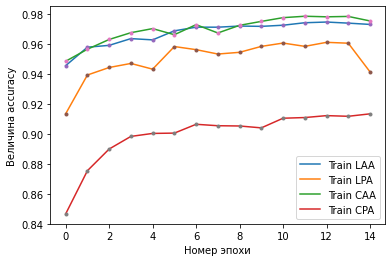

In [ ]:
fig, ax = plt.subplots()
ax.plot(acc_test[0],label='Train LAA')
ax.plot(acc_test[1],label='Train LPA')
ax.plot(acc_test[2],label='Train CAA')
ax.plot(acc_test[3],label='Train CPA')
ax.plot(acc_train[0],".")
ax.plot(acc_train[1],".")
ax.plot(acc_train[2],".")
ax.plot(acc_train[3],".")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Величина accuracy")
ax.legend()
fig.savefig("accuracy",dpi=200)

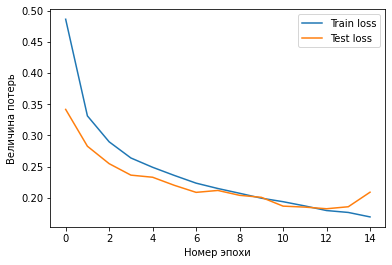

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_train, label='Train loss')
ax.plot(loss_test, label='Test loss')
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Величина потерь")
ax.legend()
fig.savefig("loss",dpi=200)